In [161]:
import pandas as pd
import os

In [162]:
# load google sheets and combine kelly and alex sheets
df_alex  = pd.read_csv("phase2_data/alex_labeled.csv")
df_kelly = pd.read_csv("phase2_data/kelly_labeled.csv")
df_alex["label"] = "Alex"
df_kelly["label"] = "Kelly"
df = pd.concat([df_alex, df_kelly], ignore_index=True)

In [163]:
# convert all N/Y to 0/1 and clean up names
df = df.rename(columns={
    "Young Little Kid (Kelly)": "young_kid",
    "In_Europe(Alex)": "in_europe",
    "Board Games (Kelly)": "board_games",
    "Kelly’s Husband (Kelly)": "husband",
    "Close up pictures of people ~ selfies (Kelly)": "close_up",
    "Vertical lines emphasis (Alex)": "vertical_lines",
    "Framing (Alex)": "framing",
    "One Point Perspective (Alex)": "one_point_perspective",
    "Flat Perspective (Kelly)": "flat_perspective",
    "Vast color distribution (Kelly)": "vast_color"
})

feature_cols = [
    "young_kid", "in_europe", "board_games", "husband",
    "close_up", "vertical_lines", "framing",
    "one_point_perspective", "flat_perspective", "vast_color"
]
pd.set_option('future.no_silent_downcasting', True)
for col in feature_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.upper()
        .str.strip()
        .replace({"Y": 1, "N": 0, "M":0, "1": 1, "0": 0})
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [164]:
df.head()

,filename,young_kid,in_europe,board_games,husband,close_up,vertical_lines,framing,one_point_perspective,flat_perspective,vast_color,label
0,1,1,0,0,0,0,0,0,1,1,0,Alex
1,2,1,0,0,0,0,1,0,1,0,0,Alex
2,3,0,0,0,0,0,0,1,1,0,0,Alex
3,4,0,0,0,0,0,0,0,1,0,0,Alex
4,5,0,0,0,0,0,0,1,1,0,0,Alex


### cleaning csv of pred percentages from model

In [148]:
cleaned_df = pd.read_csv("phase2_data/clean_model_predictions.csv")

In [149]:
cleaned_df.head()

,label,img_number,model_pred_pct,filename
0,Alex,1,0.960404,1
1,Alex,2,0.989538,2
2,Alex,3,0.989514,3
3,Alex,4,0.989515,4
4,Alex,5,0.989518,5


In [150]:
cleaned_df.describe

<bound method NDFrame.describe of      label  img_number  model_pred_pct  filename
0     Alex           1        0.960404         1
1     Alex           2        0.989538         2
2     Alex           3        0.989514         3
3     Alex           4        0.989515         4
4     Alex           5        0.989518         5
..     ...         ...             ...       ...
480  Kelly         225        0.376769       225
481  Kelly         226        0.061379       226
482  Kelly         227        0.115130       227
483  Kelly         228        0.848020       228
484  Kelly         229        0.475623       229

[485 rows x 4 columns]>

### model to see how good our features are

In [151]:
feature_cols = [
    "young_kid", "in_europe", "board_games", "husband", "close_up",
    "vertical_lines", "framing", "one_point_perspective",
    "flat_perspective", "vast_color"
]
df_partial = df.dropna(subset=feature_cols)

In [153]:
merged = df.merge(preds, on=["label", "filename"], how="inner")

In [154]:
merged.isna().sum()

filename                 0
young_kid                0
in_europe                0
board_games              0
husband                  0
close_up                 0
vertical_lines           0
framing                  0
one_point_perspective    0
flat_perspective         0
vast_color               0
label                    0
img_number               0
model_pred_pct           0
dtype: int64

In [155]:
merged.head()

,filename,young_kid,in_europe,board_games,husband,close_up,vertical_lines,framing,one_point_perspective,flat_perspective,vast_color,label,img_number,model_pred_pct
0,1,1,0,0,0,0,0,0,1,1,0,Alex,1,0.960404
1,2,1,0,0,0,0,1,0,1,0,0,Alex,2,0.989538
2,3,0,0,0,0,0,0,1,1,0,0,Alex,3,0.989514
3,4,0,0,0,0,0,0,0,1,0,0,Alex,4,0.989515
4,5,0,0,0,0,0,0,1,1,0,0,Alex,5,0.989518


In [157]:
df_final= merged.dropna(subset=feature_cols)

In [158]:
df_final.isna().sum()

filename                 0
young_kid                0
in_europe                0
board_games              0
husband                  0
close_up                 0
vertical_lines           0
framing                  0
one_point_perspective    0
flat_perspective         0
vast_color               0
label                    0
img_number               0
model_pred_pct           0
dtype: int64

## Linear Regression 

In [133]:
from sklearn.linear_model import LinearRegression

X = df_final[feature_cols]
y = df_final["model_pred_pct"]
reg = LinearRegression().fit(X, y)
for coef, feat in sorted(zip(reg.coef_, feature_cols), reverse=True):
    print(f"{feat}: {coef:.3f}")

in_europe: 0.301
one_point_perspective: 0.188
framing: 0.070
vertical_lines: 0.057
young_kid: -0.037
flat_perspective: -0.069
close_up: -0.135
vast_color: -0.157
husband: -0.216
board_games: -0.270


## Random Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier
X = df_final[feature_cols]
y = df_final["label"] 
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
for feat, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.3f}")

in_europe: 0.304
one_point_perspective: 0.160
vast_color: 0.125
vertical_lines: 0.120
framing: 0.104
flat_perspective: 0.065
close_up: 0.064
husband: 0.022
young_kid: 0.022
board_games: 0.012


In [136]:
group_perc = df_final.groupby("label")[feature_cols].mean() * 100
print(group_perc)

       young_kid  in_europe  board_games    husband   close_up  \
label                                                            
Alex    3.515625  55.468750     0.000000   0.000000   1.562500   
Kelly  12.227074   4.366812     6.550218  10.043668  25.327511   

       vertical_lines    framing  one_point_perspective  flat_perspective  \
label                                                                       
Alex        44.921875  48.046875              54.296875         23.828125   
Kelly        5.676856  11.353712               8.733624         56.768559   

       vast_color  
label              
Alex    21.484375  
Kelly   56.768559  


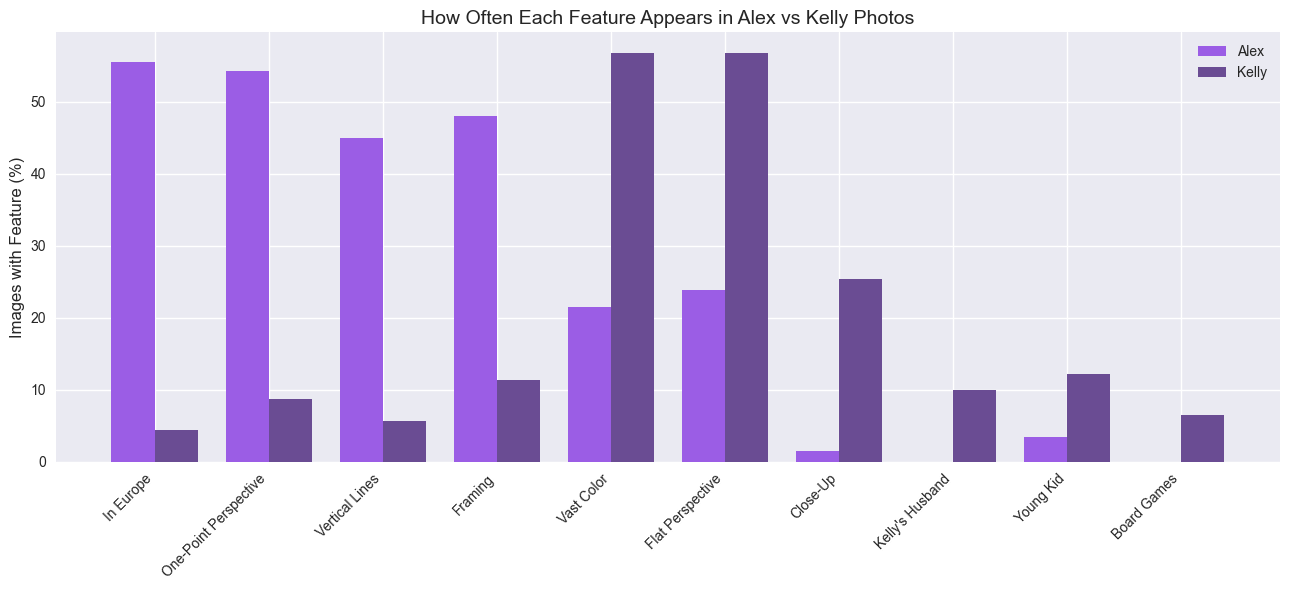

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# % per feature
group_perc = merged.groupby("label")[feature_cols].mean() * 100

pretty_names = {
    "young_kid": "Young Kid",
    "in_europe": "In Europe",
    "board_games": "Board Games",
    "husband": "Kelly's Husband",
    "close_up": "Close-Up",
    "vertical_lines": "Vertical Lines",
    "framing": "Framing",
    "one_point_perspective": "One-Point Perspective",
    "flat_perspective": "Flat Perspective",
    "vast_color": "Vast Color"
}

# Sort features by biggest Alex vs Kelly difference
diff = (group_perc.loc["Alex"] - group_perc.loc["Kelly"]).abs()
sorted_feats = diff.sort_values(ascending=False).index.tolist()

alex_vals = group_perc.loc["Alex", sorted_feats].values
kelly_vals = group_perc.loc["Kelly", sorted_feats].values
labels_pretty = [pretty_names[f] for f in sorted_feats]

x = np.arange(len(sorted_feats))
width = 0.38

plt.figure(figsize=(13, 6))
alex_color = "#9b5de5"   
kelly_color = "#6a4c93" 

plt.bar(x - width/2, alex_vals, width, label="Alex", color=alex_color)
plt.bar(x + width/2, kelly_vals, width, label="Kelly", color=kelly_color)
plt.xticks(x, labels_pretty, rotation=45, ha="right", fontsize=10)
plt.ylabel("Images with Feature (%)", fontsize=12)
plt.title("How Often Each Feature Appears in Alex vs Kelly Photos", fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig("alex_kelly_feature_percentages.png", dpi=300, bbox_inches="tight")
plt.show()